In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.optimize import minimize

## Multi-Arm Bandit: Linear-annealed policy

When solving a bandit problem using the epsilon-greedy strategy we used the same value of epsilon for every pull, so the level of exploration is the same every time you pull the arm.  Another strategy would be to start with a big epsilon (so there's lots of exploration) and reduce epsilon after each pull, so that later there is less exploration.  This is called a linear-annealed policy.  For example, if you are going to pull the arm 200 times, you could start with epsilon = 95%, then reduce epsilon by 1% after each pull until you get to epsilon = 5% on the 90th pull, and keep it at 5% for the last 110 pulls.


Your goal in this problem is to explore linear-annealed policies in bandit problems.  Go to the bandit code we examined in class, where you pull the arm 500 times where the bandits have means of [1,2,3,4] and standard deviations of [1,2,3,4].  Which of these 3 linear-annealed policies works best for the problem in the code?  Use 5000 simulations (of the 500 arm pulls) to answer this question.
 

A) initial epsilon: 100%, epsilon reduction per pull: 0.5%, final epsilon: 25%

B) initial epsilon: 50%, epsilon reduction per pull: 1%, final epsilon: 5%

C) initial epsilon: 90%, epsilon reduction per pull: 0.5%, final epsilon: 10%

D) initial epsilon: 75%, epsilon reduction per pull: 1%, final epsilon: 15%

E) epsilon is always 15%

In [2]:
def get_epsilon(n_pulls, policy):
    epsilon_list = [0]*n_pulls
    
    if policy == 1:
        start = 100
        redn = 0.5
        end = 25
    
    elif policy == 2:
        start = 50
        redn = 1
        end = 5
    
    elif policy == 3:
        start = 90
        redn = 0.5
        end = 10
    
    elif policy == 4:
        start = 75
        redn = 1
        end = 15
    
    else:
        start = 15
        redn = 15
        end = 15
           
    epsilon_list = [(start - i*redn)/100 if (start - i*redn >= end) else end/100 for i in range(n_pulls)]

    return epsilon_list


def tot_return_fun_eps_greedy(epsilon_list, n_pulls):
    n_arms = 4
    means = [1, 2, 3, 4]
    stds = [1, 2, 3, 4]
    
    avg_so_far = np.zeros(n_arms)
    pulls_per_arm = np.zeros(n_arms)
    tot_return = 0
    for pull in range(n_pulls):
        if np.random.random() < epsilon_list[pull]:
            this_choice = np.random.choice(n_arms)
        else:
            this_choice = np.argmax(avg_so_far)

        payout = np.random.normal(loc=means[this_choice],scale = stds[this_choice])
        avg_so_far[this_choice] *= pulls_per_arm[this_choice]
        avg_so_far[this_choice] += payout
        pulls_per_arm[this_choice] += 1
        avg_so_far[this_choice] /= pulls_per_arm[this_choice]
        tot_return += payout
    return tot_return

In [3]:
n_pulls = 500
n_sims = 5000
avg_payout_list = []

for p in range(1, 6):
    payout_list = []
    for i in range(n_sims):
        payput_list = []
        epsilon_list = get_epsilon(n_pulls, policy=p)
        payout = tot_return_fun_eps_greedy(epsilon_list, n_pulls)
        payout_list.append(payout)
    avg_payout_list.append(np.mean(payout_list))

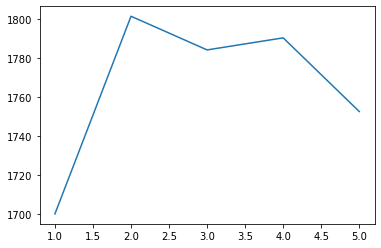

In [4]:
plt.figure()
plt.plot(range(1, 6), avg_payout_list)

In [5]:
print('Best policy is ', range(1, 6)[np.argmax(avg_payout_list)])

Best policy is  2


## Ore Mining maximization

Think back to the mining example we did in class.  We made the assumption that the number of tons extracted per year must be an integer to make the problem solvable.  If the number of tons extracted is not an integer then we have to be able to evaluate the value function at every single possible number between 0-M, not just the integers.  One way to address this concern is by combining interpolation with non-linear optimization. 

 

At each time step, t, you can find the value function at s=0,1,2,...,M by using scipy.optimize.minimize to pick x.  To do this you need an objective function that can be evaluated at any value of x.  So when you evaluate v(s-x,t+1), you must be able to evaluate this at every possible value of s-x.  But you only found v at integers of s at t+1.  To resolve this, you can use scipy.interpolate.CubicSpline on v[ : ,t+1] so that when scipy.optimize evaluates different (non-integer) values of x it calls the interpolated value of v.  Information about CubicSpline can be found at https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html (Links to an external site.)

 

At t=T things are easy, the terminal condition still says v(s,T)=0.  Store this for every integer value of s.

At t, use v(s,t+1) at each integer value of s and scipy.interpolate.CubicSpline to create an interpolating function of v(s,t+1) for non-integer values of s; call this interpolating function something like Vcs.  Then for each integer value of s in the s-loop, the objective is max_x p*x - x^2/(1+s) + delta * Vcs(s-x).  Now you can create a user defined function that returns the objective for any non-integer value of x. Then use scipy.optimize to find the optimal x, and save v[s,t].  Do this for every integer value of s = 0, 1, 2, ..., M.  For each integer value of s, the optimal x may or may not be an integer.

 

 

Each time you call scipy.optimize you need an initial guess of x.  An easy way to get a guess is to just start at the midpoint between 0 and s.  You also will need to use the L-BFGS-B algorithm since you know that x is between 0 and s.

If you allow non-integer values for ore extraction, how much more profits can you make? That is, how much bigger is v(M,0) when you allow non-integer values of x, than when only integer values of x are allowed (like the problem we solved in class)?  Round to 3 decimal places.

 

If you're very careful with calculus this problem is actually solvable in closed form, but I won't ask you to do that...

**Integer problem**

In [6]:
start_ore = 100
n_years = 15
price = 1
delta = 0.9

In [7]:
# value function and optimal policy init
U = np.zeros((start_ore+1, n_years+1))
V = np.zeros((start_ore+1, n_years+1))

# terminal & boundary condition
V[0, :] = 0
V[:, -1] = 0

for t in reversed(range(n_years)):
    for s in range(start_ore+1):
        # for remaining ore s, at time t, identifying the ore to extract 
        possible_profit = [price*x - x*x/(1+s) + delta*V[s-x, t+1] for x in range(s+1)]
        
        V[s, t] = np.max(possible_profit)
        U[s, t] = np.argmax(possible_profit)


In [8]:
s=start_ore # at the initial time there are 100 tons of ore
for t in range(n_years+1):
    si=s
    print("Year: ", t , ", Init Ore: ",s, ", Mine: ", U[si,t], sep='')
    s=int(s-U[si,t]) # remove this amount from the mine

Year: 0, Init Ore: 100, Mine: 24.0
Year: 1, Init Ore: 76, Mine: 18.0
Year: 2, Init Ore: 58, Mine: 14.0
Year: 3, Init Ore: 44, Mine: 11.0
Year: 4, Init Ore: 33, Mine: 8.0
Year: 5, Init Ore: 25, Mine: 6.0
Year: 6, Init Ore: 19, Mine: 5.0
Year: 7, Init Ore: 14, Mine: 3.0
Year: 8, Init Ore: 11, Mine: 3.0
Year: 9, Init Ore: 8, Mine: 2.0
Year: 10, Init Ore: 6, Mine: 2.0
Year: 11, Init Ore: 4, Mine: 1.0
Year: 12, Init Ore: 3, Mine: 1.0
Year: 13, Init Ore: 2, Mine: 1.0
Year: 14, Init Ore: 1, Mine: 1.0
Year: 15, Init Ore: 0, Mine: 0.0


In [9]:
V[100, 0]

58.113941952344646

**Continuous values of ores to be mined**

In [10]:
# # np.argmin([get_value_fn(x, s, t, V) for x in range(s)])
# s=44
# t=3

# Vcs = CubicSpline(np.arange(0, s+1),V[:s+1, t+1]) 

# plt.plot([get_value_fn(x, s, Vcs) for x in range(s)])
# plt.plot([price*x - x*x/(1+s) + delta*V[s-x,t] for x in range(s)], color='r')


In [11]:
def get_value_fn(x, s, Vcs, price=1, delta=0.9):
    return - (price*x - x*x/(1+s) + delta*Vcs(s-x))

def opt_mod(s, Vcs):
    opt_mod_st = minimize(get_value_fn, [s/2], bounds=[(0, s)], args=(s, Vcs), method='L-BFGS-B')
    return -opt_mod_st.fun[0], opt_mod_st.x[0]

In [12]:
# value function and optimal policy init
Ut = np.zeros((start_ore+1, n_years+1))
Vt = np.zeros((start_ore+1, n_years+1))

# terminal & boundary condition
Vt[0, :] = 0
Vt[:, -1] = 0

s_opt = 0
for t in reversed(range(n_years)):
    s_vec = np.arange(start_ore+1)
    v_vec = Vt[:, t+1]
    Vcs = CubicSpline(s_vec, v_vec) 
    for s in range(start_ore+1):
        if s == 0:
            possible_profit = [price*x - x*x/(1+s) + delta*Vt[s-x, t+1] for x in range(s+1)]
            Vt[s, t] = np.max(possible_profit)
            Ut[s, t] = np.argmax(possible_profit)
        else:
            Vt[s, t], Ut[s, t] = opt_mod(s, Vcs)


In [13]:
Vt[start_ore, 0] - V[start_ore, 0]

0.043821225226835736

## Pong
Write a python script that plays pong by tracking the ball.

 

To do this you can find the y location of the center of the ball, and the y location of the center of your paddle.  At each step, if your paddle is above the ball click the down button, and if your paddle is below the ball click the up button.  If the ball isn't on the screen then play the NOOP action.  Play 500 games like this.  On average, how many points per game does this strategy score? Not counting the opponent's score.. Round to 1 decimal place.

 

To be specific.  On each screen of pixels, run the preprocessing function.  Find the y locations of all ball pixels, and take the average of those y locations.  You only need to look for the ball between your paddle and the opponent's paddle.  You don't need to look even or behind either paddle.  Find the y locations of all your paddle pixels, and take the average of those y locations.  If there are no ball pixels, play the NOOP action.  If your average paddle y location is below the average ball y location, push up.  If your average paddle y location is above the average ball y location, push down. If your average paddle y location is the same as the average ball y location, push NOOP.

 

The np.where function is a wonderful tool to help solve this problem.  It took about 15 minutes to play 500 games like this on my laptop.

In [14]:
import gym
import time
env = gym.make("Pong-v0") # create the pong 'environment'

C:\Users\gupta\anaconda3\lib\site-packages\ale_py\roms\__init__.py:94: DeprecationWarning: Automatic importing of atari-py roms won't be supported in future releases of ale-py. Please migrate over to using `ale-import-roms` OR an ALE-supported ROM package. To make this warning disappear you can run `ale-import-roms --import-from-pkg atari_py.atari_roms`.For more information see: https://github.com/mgbellemare/Arcade-Learning-Environment#rom-management
  _RESOLVED_ROMS = _resolve_roms()
C:\Users\gupta\anaconda3\lib\site-packages\gym\envs\registration.py:505: UserWarning: WARN: The environment Pong-v0 is out of date. You should consider upgrading to version `v5` with the environment ID `ALE/Pong-v5`.
  logger.warn(
C:\Users\gupta\anaconda3\lib\site-packages\gym\utils\seeding.py:138: DeprecationWarning: WARN: Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(
C:\Users\gupta\anaconda3\lib\site-packages\gym\utils\seeding.py:175: 

In [15]:
def prepro(I):
    # preprocess each frame for learning
    # save some memory and computation
    # pre-process the image from a 210x160x3 uint8 frame into an (80x80) float array 
    I = I[35:195,:,:].copy() # crop the top of the image...score image doesn't matter for how to play
    I = I[::2,::2,0].copy()
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return np.array(I.copy())

C:\Users\gupta\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
def get_action(pixels):
    paddle1_start = 10
    paddle2_start = 70
    
    ball_area = pixels[:, paddle1_start:paddle2_start]
    ball_row = np.mean(np.where(ball_area > 0)[0])
    
    paddle_area = pixels[:, paddle2_start:paddle2_start+2]
    paddle_row = np.mean(np.where(paddle_area > 0)[0])
    
    if ball_row > paddle_row:
        return 3
    elif ball_row < paddle_row:
        return 2 
    else:
        return 0

In [17]:
render = False
slow = True
score = 0
frame_history = []
action_history = []
reward_history = []
done = False # done gets returned from the environment to tell you if this game (first to 21 points) is over
raw_pixels = env.reset()
raw_pixels, reward, done, info = env.step(1)
pixels = prepro(raw_pixels)

paddle1_start = 10
paddle2_start = 70

ball_area = pixels[:, paddle1_start:paddle2_start]
np.mean(np.where(ball_area > 0)[0])

C:\Users\gupta\anaconda3\lib\site-packages\gym\utils\seeding.py:47: DeprecationWarning: WARN: Function `rng.randint(low, [high, size, dtype])` is marked as deprecated and will be removed in the future. Please use `rng.integers(low, [high, size, dtype])` instead.
  deprecation(
C:\Users\gupta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\gupta\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [18]:
n_sims = 500
score_list = []

for i in range(n_sims):
    render = False
    slow = True
    score = 0
    frame_history = []
    action_history = []
    reward_history = []
    done = False # done gets returned from the environment to tell you if this game (first to 21 points) is over
    raw_pixels = env.reset()
    raw_pixels, reward, done, info = env.step(1)
    pixels = prepro(raw_pixels)

    k = 0
    while not done:
        k += 1
        action = np.random.choice([0,2,3]) # we'll eventually pick the action from a NN
        if render == True: # do you actually want to visualize the playing?
            env.render()
            if slow == True: # do you want to slow it down so you can see the game better?
                time.sleep(0.005)
        raw_pixels, reward, done, info = env.step(get_action(pixels))
        frame_history.append(pixels)
        action_history.append(action) # these are the action and reward when you saw the last frame
        reward_history.append(reward)
        pixels = prepro(raw_pixels) # now this is the new frame
        if reward >= 0:
            score += reward
        
#         if k%20 == 0:
#             plt.imshow(pixels)
#             plt.show()
    score_list.append(score)

    # after a game, with all that we saved we'll do a little optimization on the NN

(array([  4.,  34.,  91.,  67., 120.,  92.,  33.,  46.,  11.,   2.]),
 array([ 0. ,  1.7,  3.4,  5.1,  6.8,  8.5, 10.2, 11.9, 13.6, 15.3, 17. ]),
 <BarContainer object of 10 artists>)

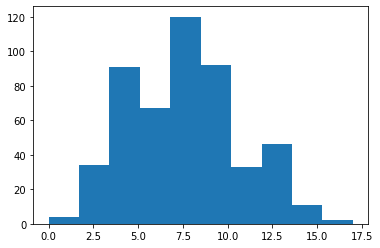

In [19]:
plt.hist(score_list)

In [20]:
score_mean = np.mean(score_list)
score_std = np.std(score_list)/n_sims**0.5
print(score_mean)
print('CI', score_mean - 4*score_std, score_mean + 4*score_std)

7.586
CI 7.044163006061787 8.127836993938214


In [21]:
np.median(score_list)

7.0